# Recommender Systems 2024/25

### Practice 7 – Graph-based Models

## Graph-based Recommenders

### What is a Graph?

In layman terms, a graph is a set of **interconnected entities**. Each entity is represented by a *node*, while the connections are called *edges*. Thus, mathematically speaking, a graph $G \in \mathbb{R}^{n\times n}$ can be represented as two sets, $N$ (nodes) and $E$ (edges).$$G = (N,E) \\ N = \{x_i | i \in [1, |N|]_{\mathbb{N}}\} \\ E = \{\{x_i, x_j\} | x_i,x_j \in N\}$$

### Graph Notation

#### Graph Chart

Nodes are usually represented graphically as circles, with lines (=edges) connecting one another

In [1]:
!pip install plotly

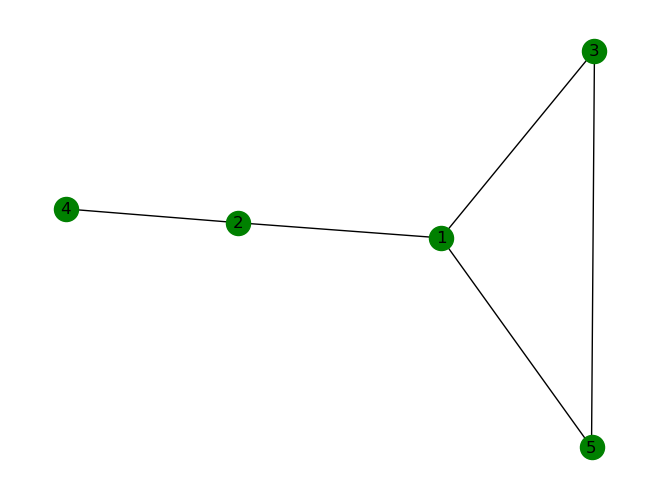

In [2]:
import networkx as nx
import plotly.graph_objects as go

G = nx.Graph()
G.add_nodes_from([1,2,3,4,5])
G.add_edges_from([(1,2),(1,3),(1,5),(2,4),(3,5)])

nx.draw(G, with_labels=True, node_color="green")

In [3]:
# Draw a more beautiful, interactive graph

def setup_plotly_graph(G : nx.Graph):
    pos = nx.spring_layout(G)
    edge_x, edge_y = [], []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x += [x0, x1, None]
        edge_y += [y0, y1, None]

    node_x, node_y = zip(*pos.values())

    return edge_x, edge_y, node_x, node_y

def draw_plotly(G : nx.Graph):
    edge_x, edge_y, node_x, node_y = setup_plotly_graph(G)

    edge_trace = go.Scatter(x=edge_x, y=edge_y,
                            line=dict(width=1, color='gray'),
                            hoverinfo='none',
                            mode='lines')
    node_trace = go.Scatter(x=node_x, y=node_y,
                            mode='markers+text',
                            marker=dict(size=25, color='blue'),
                            text=list(G.nodes),
                            textposition="top center")

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(title="Example Graph",
                                    showlegend=False,
                                    hovermode='closest'))
    
    return fig

fig = draw_plotly(G)
fig.show()


#### Adjacency Lists

For each node in the graph, its adjacency list contains all nodes it is connected to. Pros: easily readable, cons: redundant

In [4]:
for k,v in G.adj.items():
    print("{}: {}".format(k, list(v.keys())))

1: [2, 3, 5]
2: [1, 4]
3: [1, 5]
4: [2]
5: [1, 3]


#### Adjacency Matrices

##### Node-2-Edge

In [5]:
import numpy as np

def node_to_edge_adjacency_matrix(G : nx.Graph):
    # Get the list of nodes and edges
    nodes = list(G.nodes)
    edges = [(x[0] - 1,x[1] - 1) for x in list(G.edges)]

    # Initialize the node-to-edge adjacency matrix
    n = len(nodes)
    m = len(edges)
    matrix = np.zeros((n, m), dtype=np.int32)

    # Populate the matrix
    for edge_index, (u, v) in enumerate(edges):
        matrix[u, edge_index] = 1
        matrix[v, edge_index] = 1

    return matrix

node_to_edge_adjacency_matrix(G)

array([[1, 1, 1, 0, 0],
       [1, 0, 0, 1, 0],
       [0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 1]], dtype=int32)

##### Node-2-Node

In [6]:
a = nx.to_numpy_array(G, dtype=np.int32)
a

array([[0, 1, 1, 0, 1],
       [1, 0, 0, 1, 0],
       [1, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [1, 0, 1, 0, 0]], dtype=int32)

### For our purposes, the most convenient form of graph representation are n2n adjacency matrices.

### Graphs in Recommendation
- Nodes: users, items
- Edges: interactions

The graph representation of a recommendation scenario is inherently *bipartite*.

> **Bipartite Graph**: a graph $G$ is bipartite if its set of nodes $N$ can be divided into two **disjoint** sets of nodes, $N_1$ and $N_2$, such that for every edge $e$ in $G$, $e$ connects a node belonging to $N_1$ to a node in $N_2$ or vice versa, thus there is no inter-set connections among nodes within $N_1$ nor $N_2$.

In our case, class $N_1$ is defined by the *user nodes*, and class $N_2$ by *item nodes*, since the edges define user-item interactions.

Consequently, the graph's adjacency matrix will **contain the URM**.

[image]

> **Path**: a sequence of $m + 1$ nodes $n_0 \rightarrow n_1 \rightarrow n_2 \rightarrow ... \rightarrow n_m$ such that $\forall i = 1, ..., m, (n_{i-1}, n_{i}) \in E$.

I.e., a *path* is a sequence of connected nodes within a graph. A path will have a starting node $A$ and a destination node $B$. In the context of recommendation, we can think of paths as **collaborative signals**!

### Random Walks

In [7]:
import time
import numpy as np

#### Illustrative Example
Let's create a graph $G$ with 2 users, 3 items and the following adjacency matrix: $$\begin{bmatrix}0 & 0 & 1 & 0 & 1 \\ 0 & 0 & 1 & 1 & 0 \\ 1 & 1 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 \\ 1 & 0 & 0 & 0 & 0\end{bmatrix}.$$

It corresponds to the following schema:

In [8]:
G = nx.from_dict_of_dicts({
    0 : {2 : {}, 4 : {}},
    1 : {2 : {}, 3 : {}},
    2 : {0 : {}, 1 : {}},
    3 : {1 : {}},
    4 : {0 : {}}
})

draw_plotly(G)

In [9]:
a = nx.to_numpy_array(G, dtype=np.int32)
a

array([[0, 0, 1, 0, 1],
       [0, 0, 1, 1, 0],
       [1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0]], dtype=int32)

In [10]:
# Transition probability function
def transition(g : np.ndarray, n0 : int, hops : int):
    # initial state
    state = np.zeros(g.shape[1], dtype=np.float32)
    state[n0] = 1

    # compute transition probability matrix (can be done once)
    transition_probability_matrix = np.array([x / x.sum().astype(np.float32) for x in g], dtype=np.float32)
    # print(transition_probability_matrix)

    j = 0
    print("Hop: 0, state: {}".format(state))
    while j != hops:
        state = state.dot(transition_probability_matrix)
        print("Hop: {}, state: {}".format(j+1, state))
        j += 1
    return state

In [11]:
transition(g=a, n0=0, hops=3)

Hop: 0, state: [1. 0. 0. 0. 0.]
Hop: 1, state: [0.  0.  0.5 0.  0.5]
Hop: 2, state: [0.75 0.25 0.   0.   0.  ]
Hop: 3, state: [0.    0.    0.5   0.125 0.375]


array([0.   , 0.   , 0.5  , 0.125, 0.375], dtype=float32)

#### Steady State

In [12]:
transition(g=a, n0=0, hops=50)

Hop: 0, state: [1. 0. 0. 0. 0.]
Hop: 1, state: [0.  0.  0.5 0.  0.5]
Hop: 2, state: [0.75 0.25 0.   0.   0.  ]
Hop: 3, state: [0.    0.    0.5   0.125 0.375]
Hop: 4, state: [0.625 0.375 0.    0.    0.   ]
Hop: 5, state: [0.     0.     0.5    0.1875 0.3125]
Hop: 6, state: [0.5625 0.4375 0.     0.     0.    ]
Hop: 7, state: [0.      0.      0.5     0.21875 0.28125]
Hop: 8, state: [0.53125 0.46875 0.      0.      0.     ]
Hop: 9, state: [0.       0.       0.5      0.234375 0.265625]
Hop: 10, state: [0.515625 0.484375 0.       0.       0.      ]
Hop: 11, state: [0.        0.        0.5       0.2421875 0.2578125]
Hop: 12, state: [0.5078125 0.4921875 0.        0.        0.       ]
Hop: 13, state: [0.         0.         0.5        0.24609375 0.25390625]
Hop: 14, state: [0.50390625 0.49609375 0.         0.         0.        ]
Hop: 15, state: [0.         0.         0.5        0.24804688 0.25195312]
Hop: 16, state: [0.5019531  0.49804688 0.         0.         0.        ]
Hop: 17, state: [0.     

array([0.5, 0.5, 0. , 0. , 0. ], dtype=float32)

### $P^3$, $P^3_\alpha$, $RP^3_\beta$

In [13]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Data_manager.Movielens.Movielens10MReader import Movielens10MReader

data_reader = Movielens10MReader()
data_loaded = data_reader.load_data()

URM_all = data_loaded.get_URM_all()

URM_train_val, URM_test = split_train_in_two_percentage_global_sample(URM_all, 0.8)
URM_train, URM_val = split_train_in_two_percentage_global_sample(URM_train_val, 0.8)

Movielens10M: Verifying data consistency...
Movielens10M: Verifying data consistency... Passed!
DataReader: current dataset is: Movielens10M
	Number of items: 10681
	Number of users: 69878
	Number of interactions in URM_all: 10000054
	Value range in URM_all: 0.50-5.00
	Interaction density: 1.34E-02
	Interactions per user:
		 Min: 2.00E+01
		 Avg: 1.43E+02
		 Max: 7.36E+03
	Interactions per item:
		 Min: 0.00E+00
		 Avg: 9.36E+02
		 Max: 3.49E+04
	Gini Index: 0.57

	ICM name: ICM_tags, Value range: 1.00 / 69.00, Num features: 10106, feature occurrences: 106820, density 9.90E-04
	ICM name: ICM_genres, Value range: 1.00 / 1.00, Num features: 20, feature occurrences: 21564, density 1.01E-01
	ICM name: ICM_all, Value range: 1.00 / 69.00, Num features: 10126, feature occurrences: 128384, density 1.19E-03
	ICM name: ICM_year, Value range: 1.92E+03 / 2.01E+03, Num features: 1, feature occurrences: 10681, density 1.00E+00




Spiegone di come segmentare la URM in $P_{ui}$ e $P_{iu}$ e di cosa sono a livello pratico questi due segmenti (= URM normalizzata per righe, URM normalizzata per colonne e trasposta)

In [14]:
def transition_matrix(g : np.ndarray, hops : int):
    # initial state
    state = np.diag(np.ones(g.shape))

    # compute transition probability matrix (can be done once)
    transition_probability_matrix = np.array([x / x.sum().astype(np.float32) for x in g], dtype=np.float32) # -> this is equivalent to a column-wise l1 normalization
    # print(transition_probability_matrix)

    j = 0
    print("Hop: 0, state: {}".format(state))
    while j != hops:
        state = state.dot(transition_probability_matrix)
        print("Hop: {}, state: {}".format(j+1, state))
        j += 1
    return state

In [15]:
import scipy.sparse as sps

class Incremental_Similarity_Builder:
    
    def __init__(self, matrix_size_0, matrix_size_1, initial_data_block = 10000000, additional_data_block = 10000000, dtype = np.float32):

        self._matrix_size = [matrix_size_0, matrix_size_1]
        self._initial_data_block = initial_data_block
        self._additional_data_block = additional_data_block
        self._next_cell_pointer = 0

        self._dtype_data = dtype
        self._dtype_coordinates = np.uint32
        self._max_value_of_coordinate_dtype = np.iinfo(self._dtype_coordinates).max

        self._row_array = np.zeros(self._initial_data_block, dtype=self._dtype_coordinates)
        self._col_array = np.zeros(self._initial_data_block, dtype=self._dtype_coordinates)
        self._data_array = np.zeros(self._initial_data_block, dtype=self._dtype_data)


    def add_data_lists(self, row_list_to_add, col_list_to_add, data_list_to_add):

        for data_point_index in range(len(row_list_to_add)):

            if self._next_cell_pointer == len(self._row_array):
                self._row_array = np.concatenate((self._row_array, np.zeros(self._additional_data_block, dtype=self._dtype_coordinates)))
                self._col_array = np.concatenate((self._col_array, np.zeros(self._additional_data_block, dtype=self._dtype_coordinates)))
                self._data_array = np.concatenate((self._data_array, np.zeros(self._additional_data_block, dtype=self._dtype_data)))

            self._row_array[self._next_cell_pointer] = row_list_to_add[data_point_index]
            self._col_array[self._next_cell_pointer] = col_list_to_add[data_point_index]
            self._data_array[self._next_cell_pointer] = data_list_to_add[data_point_index]

            self._next_cell_pointer += 1

    def get_SparseMatrix(self):

        shape = (self._matrix_size[0], self._matrix_size[1])

        sparseMatrix = sps.csr_matrix((self._data_array[:self._next_cell_pointer],
                                       (self._row_array[:self._next_cell_pointer], self._col_array[:self._next_cell_pointer])),
                                      shape=shape,
                                      dtype=self._dtype_data)

        sparseMatrix.eliminate_zeros()

        return sparseMatrix

In [16]:
from Recommenders.Recommender_utils import similarityMatrixTopK
from sklearn.preprocessing import normalize

def block_mul(matrix_1, matrix_2, block_dim : int = 200, topK = 100, normalize_sim : bool = False):

    # only builds SQUARE matrices!! ziopera, need to rebuild
    similarity_builder = Incremental_Similarity_Builder(matrix_1.shape[0], matrix_2.shape[1], initial_data_block=matrix_2.shape[1]*topK, dtype = np.float32)

    for current_block_start_row in range(0, matrix_1.shape[0], block_dim):

        if current_block_start_row + block_dim > matrix_2.shape[1]:
            block_dim = matrix_2.shape[1] - current_block_start_row

        similarity_block = matrix_1[current_block_start_row:current_block_start_row + block_dim, :] * matrix_2
        similarity_block = similarity_block.toarray()

        for row_in_block in range(block_dim):
            row_data = similarity_block[row_in_block, :]
            row_data[current_block_start_row + row_in_block] = 0 # <-- elements on diagonal are set to 0, prevent obvious solution

            relevant_items_partition = np.argpartition(-row_data, topK-1, axis=0)[:topK]
            row_data = row_data[relevant_items_partition]

            # Incrementally build sparse matrix, do not add zeros
            if np.any(row_data == 0.0):
                non_zero_mask = row_data != 0.0
                relevant_items_partition = relevant_items_partition[non_zero_mask]
                row_data = row_data[non_zero_mask]

            similarity_builder.add_data_lists(row_list_to_add=np.ones(len(row_data), dtype = np.int32) * (current_block_start_row + row_in_block),
                                            col_list_to_add=relevant_items_partition,
                                            data_list_to_add=row_data)

    W_sparse = similarity_builder.get_SparseMatrix()

    if normalize_sim:
        W_sparse = normalize(W_sparse, norm='l1', axis=1)

    if topK and W_sparse.get_shape()[0] == W_sparse.get_shape()[1]:
        W_sparse = similarityMatrixTopK(W_sparse, k=topK)

    return W_sparse

In [ ]:
# We don't need to compute the full matrix, we just need Pui and Piu which we can compute from the URM
def transition_matrix_blocks(URM, hops : int, alpha : float = 1., beta : float = 1., topK : int = 100, extract_similarity : bool = False, normalize_sim : bool = False):

    # compute Pui (column-wise l1 norm)
    P_ui = normalize(URM, norm='l1', axis=1)

    # compute Piu (column-wise l1 norm over TRANSPOSED URM)
    t_URM = URM.transpose(copy=True)
    t_URM.data = np.ones(t_URM.data.size, np.float32) # <- we binarize: weights, if present, are already in P_ui

    if beta != 1. : # RP3beta

        t_URM_sum = np.array(t_URM.sum(axis=1)).ravel()
        degree = np.zeros(URM.shape[1])

        non_zero_mask = (t_URM_sum!=0.0)
        degree[non_zero_mask] = np.power(t_URM_sum[non_zero_mask], -beta)

    P_iu = normalize(t_URM, norm='l1', axis=1) # <- axis is still 1, because transposition was performed beforehand
    del(t_URM) # <- save memory

    if alpha != 1. : # P3alpha
        P_ui = P_ui.power(alpha)
        P_iu = P_iu.power(alpha)

    j = 0
    state = P_ui # <- doesn't work for hops < 1, but hops < 1 makes no sense 

    # equivalence to similarity item-based model: extracting sim matrix could be useful for hybrids
    sim_matrix = P_iu if extract_similarity else None
    
    while j != hops:
        if not j % 2:
            state = block_mul(state, P_iu, topK=topK, normalize_sim=normalize_sim) # state * P_iu
            if extract_similarity and (j > 1 and j < hops - 1) :
                sim_matrix = block_mul(sim_matrix, P_iu, topK=topK, normalize_sim=normalize_sim) # sim_matrix * P_iu
        else:
            state = block_mul(state, P_ui, topK=topK, normalize_sim=normalize_sim) # state * P_ui
            if extract_similarity and (j >= 1 and j < hops - 1) :
                sim_matrix = block_mul(sim_matrix, P_ui, topK=topK, normalize_sim=normalize_sim) # sim_matrix * P_ui
        j += 1
    
    # if beta != 1.:
    #     state = state * degree

    return state, sim_matrix

In [ ]:
from typing import Optional
from Recommenders.BaseRecommender import BaseRecommender

class P3Recommender(BaseRecommender):
    def __init__(self, URM, topK : int = 100, normalize_sim : bool = False):
        super().__init__(URM)
        self.topK = topK
        self.normalize_sim = normalize_sim

    def fit(self):
        self.three_step_walk, _ = transition_matrix_blocks(self.URM_train,
                                                           3,
                                                           topK=self.topK,
                                                           normalize_sim=self.normalize_sim,
                                                           extract_similarity=False)

    def recommend(self, user_id, remove_seen : bool = True, at : Optional[int] = None):
        Pi_0 = np.zeros(self.URM_train.shape[0], dtype=np.int32)
        Pi_0[user_id] = 1

        ranking = self.three_step_walk.dot(Pi_0)

        if remove_seen:
            user_profile_start = self.URM_train.indptr[user_id]
            user_profile_end = self.URM_train.indptr[user_id+1]
            
            seen_items = self.URM_train.indices[user_profile_start:user_profile_end]
            
            ranking[seen_items] = -np.inf
            
        ranking = np.flip(np.argsort(ranking))
        return ranking[:at]

In [ ]:
class P3alphaRecommender(BaseRecommender):
    def __init__(self, URM, alpha, topK : int = 100, normalize_sim : bool = False, extract_similarity=False):
        super().__init__(URM)
        self.alpha = alpha
        self.topK = topK
        self.normalize_sim = normalize_sim
        self.extract_similarity = extract_similarity

    def fit(self):
        self.three_step_walk, self.sim_matrix = transition_matrix_blocks(self.URM_train,
                                                                         3,
                                                                         self.alpha,
                                                                         topK=self.topK,
                                                                         extract_similarity=self.extract_similarity,
                                                                         normalize_sim=self.normalize_sim) # <- only change wrt P3 is the alpha exponent

    def recommend(self, user_id, remove_seen : bool = True, at : Optional[int] = None):
        Pi_0 = np.zeros(self.URM_train.shape[0], dtype=np.int32)
        Pi_0[user_id] = 1

        ranking = self.three_step_walk.dot(Pi_0)

        if remove_seen:
            user_profile_start = self.URM_train.indptr[user_id]
            user_profile_end = self.URM_train.indptr[user_id+1]
            
            seen_items = self.URM_train.indices[user_profile_start:user_profile_end]
            
            ranking[seen_items] = -np.inf
            
        ranking = np.flip(np.argsort(ranking))
        return ranking[:at]

In [ ]:
class RP3betaRecommender(BaseRecommender):
    def __init__(self, URM, alpha, beta, topK : int = 100, normalize_sim : bool = False):
        super().__init__(URM)
        self.alpha = alpha
        self.beta = beta
        self.topK = topK
        self.normalize_sim = normalize_sim

    def fit(self):
        self.three_step_walk, _ = transition_matrix_blocks(self.URM_train,
                                                           3,
                                                           self.alpha,
                                                           self.beta,
                                                           topK=self.topK,
                                                           normalize_sim=self.normalize_sim,
                                                           extract_similarity=False) # <- only change wrt P3alpha is beta

    def recommend(self, user_id, remove_seen : bool = True, at : Optional[int] = None):
        Pi_0 = np.zeros(self.URM_train.shape[0], dtype=np.int32)
        Pi_0[user_id] = 1

        ranking = self.three_step_walk.dot(Pi_0)

        if remove_seen:
            user_profile_start = self.URM_train.indptr[user_id]
            user_profile_end = self.URM_train.indptr[user_id+1]
            
            seen_items = self.URM_train.indices[user_profile_start:user_profile_end]
            
            ranking[seen_items] = -np.inf
            
        ranking = np.flip(np.argsort(ranking))
        return ranking[:at]

In [21]:
def precision(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    precision_score = np.sum(is_relevant, dtype=np.float32) / len(is_relevant)
    
    return precision_score

def recall(recommended_items, relevant_items):
    
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    recall_score = np.sum(is_relevant, dtype=np.float32) / relevant_items.shape[0]
    
    return recall_score

def AP(recommended_items, relevant_items):
   
    is_relevant = np.in1d(recommended_items, relevant_items, assume_unique=True)
    
    # Cumulative sum: precision at 1, at 2, at 3 ...
    p_at_k = is_relevant * np.cumsum(is_relevant, dtype=np.float32) / (1 + np.arange(is_relevant.shape[0]))
    
    ap_score = np.sum(p_at_k) / np.min([relevant_items.shape[0], is_relevant.shape[0]])

    return ap_score

def evaluate_recommender(URM_test : sps.csr_matrix, recommender : BaseRecommender, cutoff : int = 10):
    
    cumulative_precision = 0.0
    cumulative_recall = 0.0
    cumulative_AP = 0.0
    
    num_eval = 0

    for user_id in range(URM_test.shape[0]):

        relevant_items = URM_test.indices[URM_test.indptr[user_id]:URM_test.indptr[user_id+1]]
        
        if len(relevant_items)>0:
            
            recommended_items = recommender.recommend(user_id, at=cutoff)
            num_eval+=1

            cumulative_precision += precision(recommended_items, relevant_items)
            cumulative_recall += recall(recommended_items, relevant_items)
            cumulative_AP += AP(recommended_items, relevant_items)
            
    cumulative_precision /= num_eval
    cumulative_recall /= num_eval
    MAP = cumulative_AP / num_eval
    
    print("Recommender results are: Precision = {:.4f}, Recall = {:.4f}, MAP = {:.4f}".format(
        cumulative_precision, cumulative_recall, MAP)) 
    
    return MAP

In [23]:
# PRAXIS WHEN USING THE COURSE'S FRAMEWORK: USE EvaluatorHoldout FOR EVALUATIONS
# from Evaluation.Evaluator import EvaluatorHoldout
# evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])
from Utils.seconds_to_biggest_unit import seconds_to_biggest_unit

models = {
    'P3' : P3Recommender(URM_train_val),
    'P3alpha' : P3alphaRecommender(URM_train_val, alpha=0.5, extract_similarity=True),
    'RP3beta' : RP3betaRecommender(URM_train_val, alpha=0.5, beta=0.3)
}

for model_name, model_obj in models.items():
    time_start = time.time()
    model_obj.fit()
    time_end_value, time_unit = seconds_to_biggest_unit(time.time() - time_start)
    # PRAXIS WHEN USING THE COURSE'S FRAMEWORK: result_df, _ = evaluator_test.evaluateRecommender(model_obj)
    _ = evaluate_recommender(URM_test, model_obj)
    print("{} trained in {:.2f} {}".format(model_name, time_end_value, time_unit))

Recommender_Base_Class: URM Detected 38 ( 0.4%) items with no interactions.
Recommender_Base_Class: URM Detected 38 ( 0.4%) items with no interactions.
Recommender_Base_Class: URM Detected 38 ( 0.4%) items with no interactions.
Recommender results are: Precision = 0.0012, Recall = 0.0001, MAP = 0.0005
P3 trained in 3.22 min
Recommender results are: Precision = 0.0008, Recall = 0.0001, MAP = 0.0003
P3alpha trained in 3.37 min
Recommender results are: Precision = 0.0008, Recall = 0.0001, MAP = 0.0003
RP3beta trained in 3.26 min


In [ ]:
# Create and launch optuna study for each recommender. Optimize for MAP@10.
import pandas as pd

import optuna

def objective_function_P3alpha(optuna_trial):
    recommender_instance = P3alphaRecommender(URM_train,
                                              alpha=optuna_trial.suggest_float("alpha", 0.01, 0.99),
                                              topK=optuna_trial.suggest_int("topK", 5, 150),
                                              normalize_sim=optuna_trial.suggest_int("normalize_sim", 0, 1))

    recommender_instance.fit()

    evaluation = evaluate_recommender(URM_val, recommender_instance)
    return evaluation

def objective_function_RP3beta(optuna_trial):
    recommender_instance = RP3betaRecommender(URM_train,
                                              alpha=optuna_trial.suggest_float("alpha", 0.01, 0.99),
                                              beta=optuna_trial.suggest_float("beta", 0.01, 0.99),
                                              topK=optuna_trial.suggest_int("topK", 5, 150),
                                              normalize_sim=optuna_trial.suggest_int("normalize_sim", 0, 1))
    
    recommender_instance.fit()
    
    evaluation = evaluate_recommender(URM_val, recommender_instance)
    return evaluation

class SaveResults(object):
    
    def __init__(self):
        self.results_df = pd.DataFrame(columns = ["result"])
    
    def __call__(self, optuna_study, optuna_trial):
        hyperparam_dict = optuna_trial.params.copy()
        hyperparam_dict["result"] = optuna_trial.values[0]
        
        self.results_df = pd.concat([self.results_df, pd.DataFrame([hyperparam_dict])], ignore_index=True)

optuna_study_P3alpha = optuna.create_study(direction="maximize")
optuna_study_RP3beta = optuna.create_study(direction="maximize")
save_results_P3alpha = SaveResults()
save_results_RP3beta = SaveResults()

[I 2024-12-03 19:52:10,255] A new study created in memory with name: no-name-45c7f243-5732-4b1c-a399-1e2712acefee
[I 2024-12-03 19:52:10,260] A new study created in memory with name: no-name-d6e1f9ef-ded3-4472-9efb-cc86b5654f69


In [29]:
optuna_study_P3alpha.optimize(objective_function_P3alpha,
                              callbacks=[save_results_P3alpha],
                              n_trials=50)

P3alpha_optimal = P3alphaRecommender(URM_train_val,
                                     alpha=optuna_study_P3alpha.best_trial.params['alpha'],
                                     topK=optuna_study_P3alpha.best_trial.params['topK'],
                                     normalize_sim=optuna_study_P3alpha.best_trial.params['normalize_sim'])
P3alpha_optimal.fit()
_ = evaluate_recommender(URM_test, P3alpha_optimal)

Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 19:56:00,896] Trial 0 finished with value: 0.000267417932129221 and parameters: {'alpha': 0.11695691030736012}. Best is trial 0 with value: 0.000267417932129221.


Recommender results are: Precision = 0.0008, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


/var/folders/pp/q0kl1bl507q_7gsf1tczbrg80000gn/T/ipykernel_90667/2301438212.py:33: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

[I 2024-12-03 19:59:49,256] Trial 1 finished with value: 0.00026792623698722513 and parameters: {'alpha': 0.21482630628649535}. Best is trial 1 with value: 0.00026792623698722513.


Recommender results are: Precision = 0.0008, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 20:03:51,785] Trial 2 finished with value: 0.00035855836080573076 and parameters: {'alpha': 0.9571134099221613}. Best is trial 2 with value: 0.00035855836080573076.


Recommender results are: Precision = 0.0010, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 20:07:42,197] Trial 3 finished with value: 0.0002449225929200655 and parameters: {'alpha': 0.3673450596269118}. Best is trial 2 with value: 0.00035855836080573076.


Recommender results are: Precision = 0.0008, Recall = 0.0001, MAP = 0.0002
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 20:11:32,332] Trial 4 finished with value: 0.00024110916678804454 and parameters: {'alpha': 0.5017647325451496}. Best is trial 2 with value: 0.00035855836080573076.


Recommender results are: Precision = 0.0007, Recall = 0.0001, MAP = 0.0002
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 20:15:26,991] Trial 5 finished with value: 0.00030695288105142153 and parameters: {'alpha': 0.7315852012490363}. Best is trial 2 with value: 0.00035855836080573076.


Recommender results are: Precision = 0.0008, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 20:19:14,286] Trial 6 finished with value: 0.00025443450400728897 and parameters: {'alpha': 0.17651817795488978}. Best is trial 2 with value: 0.00035855836080573076.


Recommender results are: Precision = 0.0008, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 20:23:04,760] Trial 7 finished with value: 0.00026005833880957753 and parameters: {'alpha': 0.3244136749434458}. Best is trial 2 with value: 0.00035855836080573076.


Recommender results are: Precision = 0.0008, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 20:26:54,033] Trial 8 finished with value: 0.00024537562247400446 and parameters: {'alpha': 0.3742898642693653}. Best is trial 2 with value: 0.00035855836080573076.


Recommender results are: Precision = 0.0008, Recall = 0.0001, MAP = 0.0002
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 20:30:55,013] Trial 9 finished with value: 0.00036338440771429176 and parameters: {'alpha': 0.9851269675917077}. Best is trial 9 with value: 0.00036338440771429176.


Recommender results are: Precision = 0.0011, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 20:34:55,414] Trial 10 finished with value: 0.00036418276545651545 and parameters: {'alpha': 0.9770294140549688}. Best is trial 10 with value: 0.00036418276545651545.


Recommender results are: Precision = 0.0011, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 20:38:54,337] Trial 11 finished with value: 0.00035754061139273147 and parameters: {'alpha': 0.9521436914615018}. Best is trial 10 with value: 0.00036418276545651545.


Recommender results are: Precision = 0.0010, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 20:42:49,021] Trial 12 finished with value: 0.000312643957976182 and parameters: {'alpha': 0.7579983048949656}. Best is trial 10 with value: 0.00036418276545651545.


Recommender results are: Precision = 0.0009, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 20:46:44,034] Trial 13 finished with value: 0.0003207152920667299 and parameters: {'alpha': 0.7800601575582734}. Best is trial 10 with value: 0.00036418276545651545.


Recommender results are: Precision = 0.0009, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 20:50:34,764] Trial 14 finished with value: 0.0002666423683268181 and parameters: {'alpha': 0.5937176330908553}. Best is trial 10 with value: 0.00036418276545651545.


Recommender results are: Precision = 0.0008, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 20:54:31,987] Trial 15 finished with value: 0.0003497165915492394 and parameters: {'alpha': 0.8582176779215048}. Best is trial 10 with value: 0.00036418276545651545.


Recommender results are: Precision = 0.0010, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 20:58:23,534] Trial 16 finished with value: 0.00027715949216013905 and parameters: {'alpha': 0.6282228199072102}. Best is trial 10 with value: 0.00036418276545651545.


Recommender results are: Precision = 0.0008, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 21:02:23,101] Trial 17 finished with value: 0.000363659644537628 and parameters: {'alpha': 0.9834805277155828}. Best is trial 10 with value: 0.00036418276545651545.


Recommender results are: Precision = 0.0011, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 21:06:19,237] Trial 18 finished with value: 0.0003457276520805983 and parameters: {'alpha': 0.843255572934572}. Best is trial 10 with value: 0.00036418276545651545.


Recommender results are: Precision = 0.0009, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 21:10:05,701] Trial 19 finished with value: 0.00026698712666660776 and parameters: {'alpha': 0.014030125095582546}. Best is trial 10 with value: 0.00036418276545651545.


Recommender results are: Precision = 0.0007, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 21:13:57,942] Trial 20 finished with value: 0.0002863534277868619 and parameters: {'alpha': 0.6423783190656585}. Best is trial 10 with value: 0.00036418276545651545.


Recommender results are: Precision = 0.0008, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 21:17:58,828] Trial 21 finished with value: 0.0003629404957362814 and parameters: {'alpha': 0.9767193931396003}. Best is trial 10 with value: 0.00036418276545651545.


Recommender results are: Precision = 0.0011, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 21:21:56,363] Trial 22 finished with value: 0.0003549147495253747 and parameters: {'alpha': 0.9050791250149208}. Best is trial 10 with value: 0.00036418276545651545.


Recommender results are: Precision = 0.0010, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 21:25:52,871] Trial 23 finished with value: 0.0003383446949726384 and parameters: {'alpha': 0.8363798946695129}. Best is trial 10 with value: 0.00036418276545651545.


Recommender results are: Precision = 0.0010, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 21:29:54,215] Trial 24 finished with value: 0.00036601140927863997 and parameters: {'alpha': 0.9857634202778721}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0011, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 21:33:48,143] Trial 25 finished with value: 0.00030233596854071696 and parameters: {'alpha': 0.7142767281557556}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0008, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 21:37:46,122] Trial 26 finished with value: 0.0003502140692858284 and parameters: {'alpha': 0.8951459125725756}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0010, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 21:41:42,446] Trial 27 finished with value: 0.00032864131479092034 and parameters: {'alpha': 0.805120329328623}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0009, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 21:45:39,869] Trial 28 finished with value: 0.0003491034345680596 and parameters: {'alpha': 0.8946442106019464}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0010, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 21:49:33,046] Trial 29 finished with value: 0.0002916974669778508 and parameters: {'alpha': 0.6781347369652826}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0008, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 21:53:22,921] Trial 30 finished with value: 0.00025786043316235657 and parameters: {'alpha': 0.5438034293131342}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0008, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 21:57:23,882] Trial 31 finished with value: 0.00036500163774457806 and parameters: {'alpha': 0.9893057839979716}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0010, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 22:01:22,999] Trial 32 finished with value: 0.00035320976282677825 and parameters: {'alpha': 0.9186171407963923}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0010, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 22:05:23,199] Trial 33 finished with value: 0.00036567348912079644 and parameters: {'alpha': 0.9887286379949248}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0011, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 22:09:21,667] Trial 34 finished with value: 0.00035714513653684065 and parameters: {'alpha': 0.930753118924713}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0010, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 22:13:18,711] Trial 35 finished with value: 0.00034299294915059674 and parameters: {'alpha': 0.8475543445229526}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0009, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 22:17:13,990] Trial 36 finished with value: 0.0003247201872932456 and parameters: {'alpha': 0.7936457710149851}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0009, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 22:21:14,851] Trial 37 finished with value: 0.00036493895441007087 and parameters: {'alpha': 0.9897423138106054}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0010, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 22:25:18,835] Trial 38 finished with value: 0.00034793581500073845 and parameters: {'alpha': 0.8789798668819806}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0010, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 22:29:24,460] Trial 39 finished with value: 0.0002460537421836733 and parameters: {'alpha': 0.4375897042339283}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0008, Recall = 0.0001, MAP = 0.0002
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 22:33:32,211] Trial 40 finished with value: 0.00026857301502964054 and parameters: {'alpha': 0.258693778813749}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0008, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 22:38:12,557] Trial 41 finished with value: 0.00036409671833369196 and parameters: {'alpha': 0.9849727618048679}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0011, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 22:42:27,942] Trial 42 finished with value: 0.00035847801216786244 and parameters: {'alpha': 0.9311514243808667}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0010, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 22:46:47,148] Trial 43 finished with value: 0.0003591082646039076 and parameters: {'alpha': 0.9524482513774833}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0010, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 22:51:05,869] Trial 44 finished with value: 0.00035370154207841253 and parameters: {'alpha': 0.940156881984353}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0010, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 22:55:22,151] Trial 45 finished with value: 0.0003378893860247176 and parameters: {'alpha': 0.8160073628064539}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0009, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 22:59:38,696] Trial 46 finished with value: 0.0003651879782026132 and parameters: {'alpha': 0.9898018434568384}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0010, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 23:03:49,477] Trial 47 finished with value: 0.0003090977907885599 and parameters: {'alpha': 0.7267974463918954}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0008, Recall = 0.0001, MAP = 0.0003
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 23:08:04,337] Trial 48 finished with value: 0.00035090757490487644 and parameters: {'alpha': 0.894889920575522}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0010, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 75 ( 0.7%) items with no interactions.


[I 2024-12-03 23:12:24,286] Trial 49 finished with value: 0.0003654033809339197 and parameters: {'alpha': 0.9896156544208515}. Best is trial 24 with value: 0.00036601140927863997.


Recommender results are: Precision = 0.0010, Recall = 0.0001, MAP = 0.0004
Recommender_Base_Class: URM Detected 38 ( 0.4%) items with no interactions.
Recommender results are: Precision = 0.0012, Recall = 0.0001, MAP = 0.0004


In [ ]:
optuna_study_RP3beta.optimize(objective_function_RP3beta,
                              callbacks=[save_results_RP3beta],
                              n_trials=50)

RP3beta_optimal = RP3betaRecommender(URM_train_val,
                                     alpha=optuna_study_RP3beta.best_trial.params['alpha'],
                                     beta=optuna_study_RP3beta.best_trial.params['beta'],
                                     topK=optuna_study_RP3beta.best_trial.params['topK'],
                                     normalize_sim=optuna_study_RP3beta.best_trial.params['normalize_sim'])

RP3beta_optimal.fit()
_ = evaluate_recommender(URM_test, RP3beta_optimal)

In [ ]:
# Plot recommendations as in Practice 04

In [47]:
# P5/P7 e come cambiano le raccomandazioni/similarity density (se la RAM regge) --> se non regge, applicare KNN come da framework (similarityMatrixTopK)
class PXRecommender:
    def __init__(self, URM, hops : int):
        self.URM = URM
        self.hops = hops
        if not hops % 2:
            raise ValueError("Number of hops must be odd.")

    def fit(self):
        self.n_step_walk, _ = transition_matrix_blocks(self.URM, self.hops, extract_similarity=False)

    def recommend(self, user_id, remove_seen : bool = True, at : Optional[int] = None):
        Pi_0 = np.zeros(self.URM.shape[0], dtype=np.int32)
        Pi_0[user_id] = 1

        ranking = self.n_step_walk.dot(Pi_0)

        if remove_seen:
            user_profile_start = self.URM.indptr[user_id]
            user_profile_end = self.URM.indptr[user_id+1]
            
            seen_items = self.URM.indices[user_profile_start:user_profile_end]
            
            ranking[seen_items] = -np.inf
            
        ranking = np.flip(np.argsort(ranking))
        return ranking[:at]

In [ ]:
# Compute recommendations on test set with P3, P5 and P7
# Visualizzazione su come scende il valore metriche vs. numero di hop
# Popularity plot, più P è alto più si vedrà short head-long tail

Possibile ibridare modelli con hops diversi PRIO

In [ ]:
from sklearn.preprocessing import normalize

class P3Recommender:
    
    def __init__(self, URM_train):    
        self.URM_train = URM_train
    
    def fit(self, topK, min_rating, implicit):
        self.topK = topK
        self.min_rating = min_rating
        self.implicit = implicit

        if self.min_rating > 0:
            self.URM_train.data[self.URM_train.data < self.min_rating] = 0
            self.URM_train.eliminate_zeros()
            if self.implicit:
                self.URM_train.data = np.ones(self.URM_train.data.size, dtype=np.float32)

        #Pui is the row-normalized urm
        Pui = normalize(self.URM_train, norm='l1', axis=1)

        #Piu is the column-normalized, "boolean" urm transposed
        X_bool = self.URM_train.transpose(copy=True)
        X_bool.data = np.ones(X_bool.data.size, np.float32)
        #ATTENTION: axis is still 1 because i transposed before the normalization
        Piu = normalize(X_bool, norm='l1', axis=1)
        del(X_bool)

        self.W_sparse = Pui * Piu * Pui #sketch

Il codice di cui sopra è giusto "idealmente", ma non utilizzabile a livello di complessità (spazio: troppi dati da caricare in memoria). Spiego come risolvere?

Equivalenza con Item-item collaborative filtering: similarity matrix risulta uguale nelle dimensioni, possibile fare ibridi

In [ ]:
from Recommenders import P3alphaRecommender

# Fit and evaluate P3alpha (maybe change alpha a couple times to show how results change)

#### Difference between $P^3_\alpha$ and $RP^3_\beta$

... Rispiegone

In [ ]:
from Recommenders import RP3betaRecommender

# Fit and evaluate RP3beta

### Adding Content Metadata to the Mix

*Tripartite graph*: users, items, metadata

#### How do Random Walks change?

Spiegone

#### Illustrative Example

Let's restart from our little graph from before, adding 4 metadata "tags":$$\begin{bmatrix}0 & 0 & 1 & 0 & 1 & 0 & 1 & 0 & 0\\ 0 & 0 & 1 & 1 & 0 & 1 & 0 & 0 & 0 \\ 1 & 1 & 0 & 0 & 0 & 0 & 0 & 1 & 1 \\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 1 & 0 \\ 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 \\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 1 & 0 & 0 & 0& 0\end{bmatrix}.$$

[image] <- NO: mostra come attaccare la ICM nella matrice di adiacenza e usare i modelli del framework direttamente

In [ ]:
# Segui quello visto prima

È possibile attaccare i metadati col framework? Nel caso, mostragli come.

- Part 1: generic structure of a graph
    - Nodes
    - Edges
    - (E.g. : Gif of my knowledge graph on Obsidian)
    - Notation: chart OR adjacency matrix OR adjacency lists
        - Adjacency matrices: node2node OR node2edge
            - For our purpose, we use node2node adjacency matrices
- Part 2: graphs in recommendation
    - Nodes: users, items
    - Edges: interactions
    - Bipartite graph: we can distinguish 2 classes of nodes, with edges only connecting nodes of class 1 to nodes of class 2 and vice-versa. No inter-class connections
        - Adjacency matrix of a graph of interactions: URM!
            - `G = [[[0][URM]], [[URM*], [0]]]`
    - Path: sequence of connected nodes that starts with node A and ends with node B
        - Recommendation idea: we can use paths as collaborative signals
- Part 3: random walks
    - Recap on mathematics (from textbook)
    - Illustrative example (from slides)
- Part 4: $P^3$, $P^3_\alpha$, $RP^3_\beta$
    - $P^3$: 3-step random walks
        - Theory recap (from textbook, don't explain)
        - Illustrative example (from slides)
    - $P^3_\alpha$: add an exponent
        - Theory recap (from textbook, don't explain)
        - Illustrative example (from slides)
    - $RP^3_\beta$: ...
        - Theory recap (from textbook, don't explain)
        - How to use (from framework), strong baseline! Good for hybrids
- Part 5: Adding item metadata, tripartite graph
    - Theory recap (from slides)
    - Illustrative example with $P^3$